# Ray et al 2013 Intepretation
**Authorship:**
Adam Klie, *09/03/2022*
***
**Description:**
Notebook to interpret the trained models on the Ray et al (2013) dataset.
***

In [58]:
# General imports
import os
import glob
import torch
import numpy as np
import pandas as pd
import xarray as xr

# EUGENe imports and settings
from eugene import preprocess as pp
from eugene import models
from eugene import interpret
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/ray13"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/ray13"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/ray13"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/ray13"
settings.figure_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures//revision/ray13"

# EUGENe packages
import seqdata as sd
import motifdata as md
import seqpro as sp

# For illustrator editing
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Eugene version: {eu.__version__}")
#print(f"SeqData version: {sd.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pytorch_lightning.__version__}")

Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
NumPy version: 1.23.5
Pandas version: 1.5.2
Eugene version: 0.0.8
PyTorch version: 2.0.0
PyTorch Lightning version: 2.0.0


# Load the test `SeqData`

In [59]:
# Load the test data
sdata_test = sd.open_zarr(os.path.join(settings.dataset_dir, "norm_setB_ST.zarr"))
keys = pd.Index(sdata_test.data_vars.keys())
target_mask = keys.str.contains("RNCMPT")
target_cols = keys[target_mask]
sdata_test

<xarray.Dataset>
Dimensions:      (_sequence: 121031, _ohe: 4, length: 41)
Dimensions without coordinates: _sequence, _ohe, length
Data variables: (12/248)
    Probe_ID     (_sequence) object dask.array<chunksize=(30258,), meta=np.ndarray>
    Probe_Set    (_sequence) object dask.array<chunksize=(30258,), meta=np.ndarray>
    RNA_Seq      (_sequence) object dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00001  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00002  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00003  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    ...           ...
    RNCMPT00285  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00287  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00288  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00289  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00291  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    ohe_seq      (_sequence, _ohe, length) float16 dask.array<chunksize=(30258, 1, 11), meta=np.ndarray>

In [60]:
# Get the MT training labels
sdata_training = sd.open_zarr(os.path.join(settings.dataset_dir, "norm_setA_sub_MT.zarr"))
keys_MT = pd.Index(sdata_training.data_vars.keys())
target_mask_MT = keys_MT.str.contains("RNCMPT")
target_cols_MT = keys_MT[target_mask_MT]
del sdata_training
len(target_cols_MT)

233

In [61]:
# Check the targets to make sure they are 244 and 233
len(target_cols), len(target_cols_MT)

(244, 233)

In [62]:
# Load in top 10 single task and multitask models
top_ST_tasks = pd.read_csv("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/ray13/performance/top_10_ST_intensities.tsv", sep="\t", index_col=0)
top_MT_tasks = pd.read_csv("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/ray13/performance/top_10_MT_intensities.tsv", sep="\t", index_col=0)

In [63]:
# Get the shared index
shared_top_10 = sorted(top_ST_tasks.index.intersection(top_MT_tasks.index))
shared_top_10

['RNCMPT00023',
 'RNCMPT00205',
 'RNCMPT00215',
 'RNCMPT00238',
 'RNCMPT00246',
 'RNCMPT00268',
 'RNCMPT00269']

In [64]:
# Get the indeces of the shared cols in the MT target cols
shared_top_10_MT_idx = np.where(target_cols_MT.isin(shared_top_10))[0]
shared_top_10_MT_idx

array([ 19, 172, 176, 194, 199, 215, 216])

In [65]:
conv_dropout=0.5
dense_dropout=0.5
batchnorm=True
arch_ST = models.zoo.DeepBind(
    input_len=41, # Length of padded sequences
    output_dim=1, # Number of multitask outputs
    conv_kwargs=dict(input_channels=4, conv_channels=[16], conv_kernels=[16], dropout_rates=conv_dropout, batchnorm=batchnorm),
    dense_kwargs=dict(hidden_dims=[32], dropout_rates=dense_dropout, batchnorm=batchnorm),
)

In [66]:
version = 0
arch_MT = models.zoo.DeepBind(
    input_len=41, # Length of padded sequences
    output_dim=len(target_cols_MT), # Number of multitask outputs
    conv_kwargs=dict(input_channels=4, conv_channels=[1024], conv_kernels=[16], dropout_rates=0.25, batchnorm=0.25),
    dense_kwargs=dict(hidden_dims=[512], dropout_rates=0.25, batchnorm=True),
)

# Feature Attribution

## Single task models

In [88]:
# Get per nuceotide feature attibutions
for i, target_col in enumerate(shared_top_10):
    print(f"Intepreting DeepBind SingleTask model on {target_col}")
    model_file = glob.glob(os.path.join(settings.logging_dir, "DeepBind_ST", target_col, "checkpoints", "*"))[0]
    model = models.SequenceModule.load_from_checkpoint(model_file, arch=arch_ST)
    interpret.attribute_sdata(
        model,
        sdata_test,
        method="InputXGradient",
        suffix=f"_{target_col}_ST",
        batch_size=512,
        transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)}
    )
    break

Intepreting DeepBind SingleTask model on RNCMPT00023


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

## Multi-task

In [30]:
model_file = glob.glob(os.path.join(settings.logging_dir, "DeepBind_MT", f"v{version}", "checkpoints", "*"))[0]
model = models.SequenceModule.load_from_checkpoint(model_file, arch=arch_MT)

Testing DeepBind MultiTask model on


In [36]:
for i, target_col in zip(shared_top_10_MT_idx, shared_top_10):
    print(f"Intepreting version{version} DeepBind MultiTask model on {target_col}, which is the {i}th index of prediction")
    interpret.attribute_sdata(
        model,
        sdata_test,
        method="InputXGradient",
        target=int(i),
        suffix=f"_{target_col}_MT",
        batch_size=512,
        transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)}
    )
    break

Intepreting version0 DeepBind MultiTask model on RNCMPT00023, which is the 19th index of prediction


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting version0 DeepBind MultiTask model on RNCMPT00205, which is the 172th index of prediction


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting version0 DeepBind MultiTask model on RNCMPT00215, which is the 176th index of prediction


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting version0 DeepBind MultiTask model on RNCMPT00238, which is the 194th index of prediction


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting version0 DeepBind MultiTask model on RNCMPT00246, which is the 199th index of prediction


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting version0 DeepBind MultiTask model on RNCMPT00268, which is the 215th index of prediction


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

Intepreting version0 DeepBind MultiTask model on RNCMPT00269, which is the 216th index of prediction


Computing saliency on batches of size 512:   0%|          | 0/237 [00:00<?, ?it/s]

## Plot feature attributions 

In [ ]:
sdata_test = sdata_test.set_index(_sequence="Probe_ID")

Plotting feature attribution scores for DeepBind models on RNCMPT00023


Importance values:   0%|          | 0/2 [00:00<?, ?it/s]

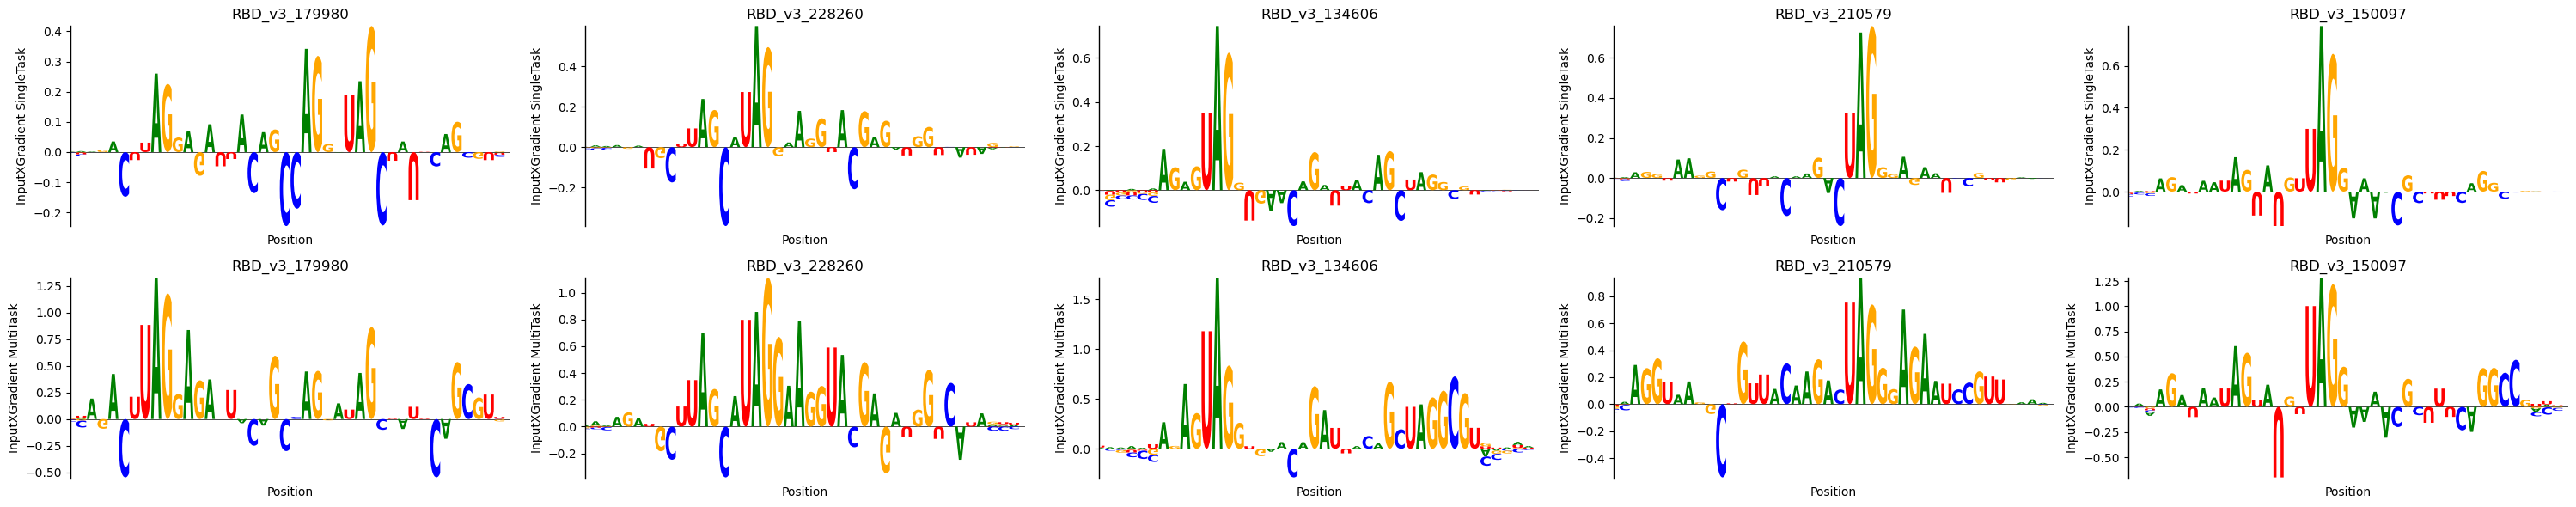

In [90]:
for i, target_col in enumerate(shared_top_10):
    print(f"Plotting feature attribution scores for DeepBind models on {target_col}")
    top5_index = sdata_test[target_col].to_series().sort_values(ascending=False).index[:5]
    pl.multiseq_track(
        sdata_test,
        seq_ids=top5_index,
        attrs_keys=[f"InputXGradient_attrs_{target_col}_ST", f"InputXGradient_attrs_{target_col}_MT"],
        id_key="_sequence",
        vocab="RNA",
        width=30,
        height=6,
        ylabs=["InputXGradient SingleTask", "InputXGradient MultiTask"],
        #save=os.path.join(eu.settings.figure_dir, "feature_attr", f"model_top5_feature_attr_{target_col}_STandMT.pdf")
    )
    break
    #plt.close()

# Filter viz

In [67]:
# Select the layer you want to interpret
layer_name = "arch.conv1d_tower.layers.1"

## Single task 

In [95]:
interpret.generate_pfms_sdata?

Signature:
interpret.generate_pfms_sdata(
    model,
    sdata,
    seq_key,
    layer_name,
    kernel_size=None,
    num_seqlets=100,
    activation_threshold=None,
    num_filters=None,
    batch_size=None,
    device=None,
    num_workers=None,
    prefetch_factor=None,
    transforms={},
    prefix='',
    suffix='',
    copy=False,
)
Docstring: <no docstring>
File:      ~/projects/ML4GLand/EUGENe/eugene/interpret/_filters.py
Type:      function

In [98]:
# Grab the pfms for the 16 filters of each single task model
for i, target_col in enumerate(shared_top_10):
    print(f"Generating pfms for single task DeepBind models on {target_col}")
    model_file = glob.glob(os.path.join(settings.logging_dir, "DeepBind_ST", target_col, "checkpoints", "*"))[0]
    model = models.SequenceModule.load_from_checkpoint(model_file, arch=arch_ST)
    interpret.generate_pfms_sdata(
        model=model, 
        sdata=sdata_test,
        seq_key="ohe_seq",
        layer_name=layer_name,
        activation_threshold=0.75, 
        batch_size=2048,
        kernel_size=16,
        transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
        suffix=f"{target_col}_ST"
    )
    break

Generating pfms for single task DeepBind models on RNCMPT00023


Getting activations on batches of size 2048:   0%|          | 0/60 [00:00<?, ?it/s]

Getting filter activators for 16 filters:   0%|          | 0/16 [00:00<?, ?it/s]

ValueError: cannot reindex or align along dimension '_num_kernels' because of conflicting dimension sizes: {1024, 16}

## Multitask

In [76]:
# Grab the pfms for all filters of the multitask model, this requires a lot of mem!
interpret.generate_pfms_sdata(
    model=model, 
    sdata=sdata_test,
    seq_key="ohe_seq",
    layer_name=layer_name,
    activation_threshold=0.75, 
    kernel_size=16,
    batch_size=2048,
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)}
)

Getting activations on batches of size 2048:   0%|          | 0/60 [00:00<?, ?it/s]

Getting filter activators for 1024 filters:   0%|          | 0/1024 [00:00<?, ?it/s]

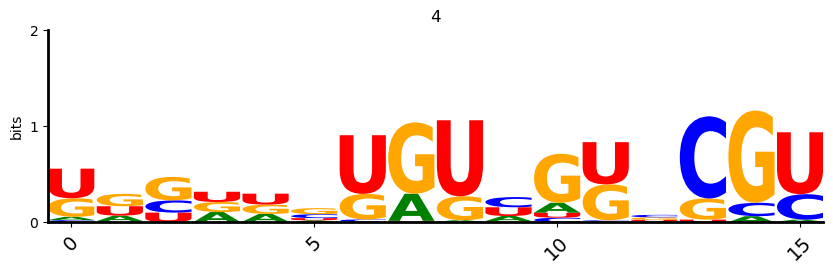

In [83]:
# Visualize a filter of choice
pl.filter_viz(
    sdata_test,
    filter_num=4,
    pfms_key=f"{layer_name}_pfms",
    vocab="RNA"
)

# Plot filter viz

In [ ]:
# Visualizations for all 16 filters for DeepBind SingleTask models
for i, target_col in enumerate(shared_top_10):
    print(f"Plotting and saving filter visualizations for DeepBind models on {target_col}")
    eu.pl.multifilter_viz(
        sdata_test,
        filter_ids=range(0,16),
        uns_key=f"pfms_{target_col}_ST",
        titles=[f"filter {i}" for i in range(16)],
        num_rows=4,
        num_cols=4,
        save=os.path.join(eu.settings.figure_dir, "filter_viz", f"filters_viz_{target_col}_0.75_ST.pdf")
    )

    # Save all the filter pfms from above as meme format for submission to TomTom
    eu.dl.motif.filters_to_meme_sdata(
        sdata_test,
        uns_key=f"pfms_{target_col}_ST", 
        vocab="RNA",
        output_dir=os.path.join(eu.settings.output_dir),
        file_name=f"{target_col}_filters_0.75_ST.meme"
    )
    #plt.close()

In [ ]:
# Visualizations for all filters of the multitask model
for i in range(32):
    start_filter = i*32
    end_filter = (i*32) + 32
    print(f"Plotting and saving filters {start_filter+1}-{end_filter}")
    eu.pl.multifilter_viz(
        sdata_test,
        filter_ids=list(sdata_test.uns["pfms_MT"].keys())[start_filter:end_filter],
        num_rows=8,
        num_cols=4,
        uns_key="pfms_MT",
        titles=[f"filter {i}" for i in range(start_filter, end_filter)],
        save=os.path.join(eu.settings.figure_dir, "filter_viz", f"filters{start_filter+1}-{end_filter}_viz_MT.pdf")
    )
    plt.tight_layout()
    plt.close()

In [ ]:
# Save all the filter pfms from above as meme format for submission to TomTom
eu.dl.motif.filters_to_meme_sdata(
    sdata_test,
    uns_key=f"pfms_MT", 
    vocab="RNA",
    output_dir=os.path.join(eu.settings.output_dir),
    file_name=f"filters_0.75_MT.meme"
)

# In silico

In [68]:
# Load the ST model for an RBP of interest
rbp = shared_top_10[0]
model_file = glob.glob(os.path.join(settings.logging_dir, "DeepBind_ST", rbp, "checkpoints", "*"))[0]
model = models.SequenceModule.load_from_checkpoint(model_file, arch=arch_ST)

In [76]:
random_seqs = sp.ohe(sp.random_seqs(10, 41), alphabet=sp.ALPHABETS["RNA"]).transpose(0, 2, 1)

In [77]:
from seqexplainer import evolution

In [78]:
random_seqs.shape

(10, 4, 41)

In [79]:
# Evolve a set of 10 random sequences across 5 rounds
X_random = torch.tensor(random_seqs, dtype=torch.float32)
evolved_seqs = []
mutation_pos = []
for random_seq in random_seqs:
    evolved_res = evolution(
        model=model,
        X=random_seq,
        rounds=5,
    )
    evolved_seqs.append(evolved_res[0])
    mutation_pos.append(evolved_res[2])
X_evolved = torch.tensor(np.array(evolved_seqs), dtype=torch.float32)
mutation_pos = np.array(mutation_pos)

In [81]:
X_evolved.shape

torch.Size([10, 4, 41])

In [83]:
from seqexplainer import attribute

In [84]:
random_scores = model.predict(X_random)

Predicting on batches: 0it [00:00, ?it/s]

In [86]:
random_scores.shape

torch.Size([10, 1])

In [87]:
# Get the scores and the feature attributions for both the original random and the evolved
random_explains = attribute(
    model=model,
    inputs=X_random,
    method="InputXGradient",
)

Computing attributions on batches of size 128:   0%|          | 0/1 [00:00<?, ?it/s]

In [88]:
evolved_scores = model.predict(X_evolved)

Predicting on batches: 0it [00:00, ?it/s]

In [92]:
evolved_explains = attribute(
    model=model,
    inputs=X_evolved,
    method="InputXGradient",
)

Computing attributions on batches of size 128:   0%|          | 0/1 [00:00<?, ?it/s]

In [93]:
import matplotlib.pyplot as plt

In [94]:
import logomaker as lm

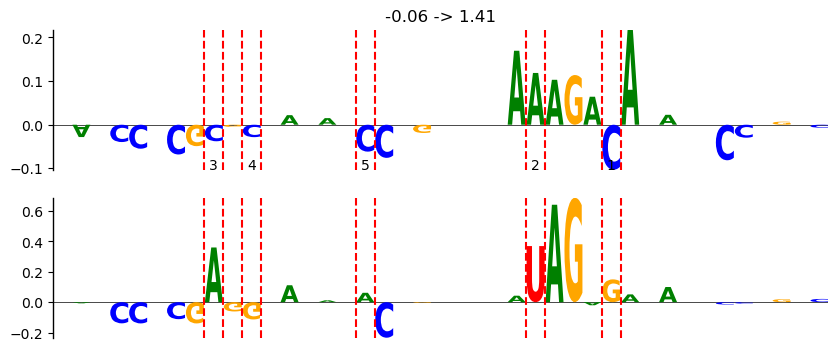

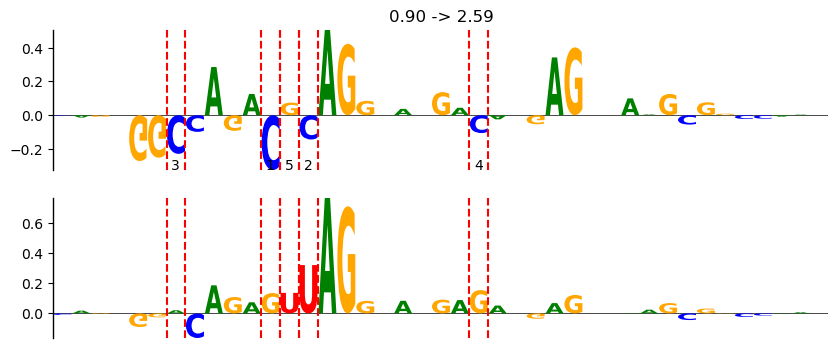

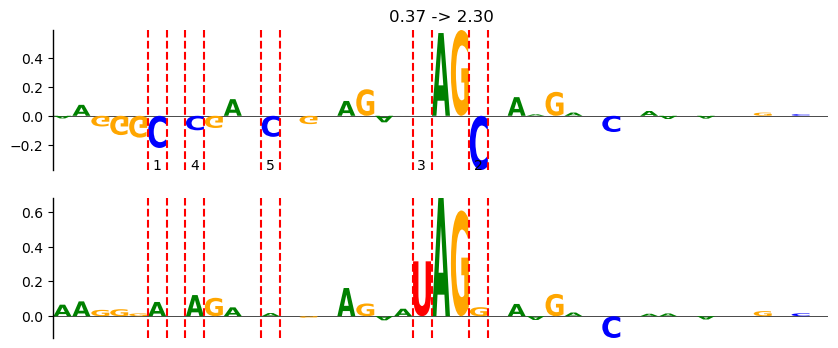

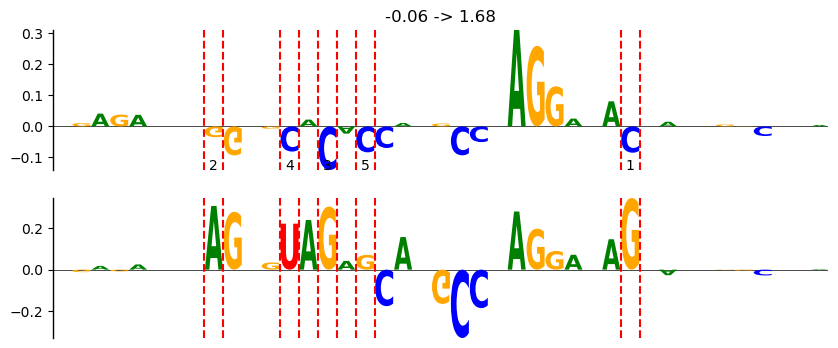

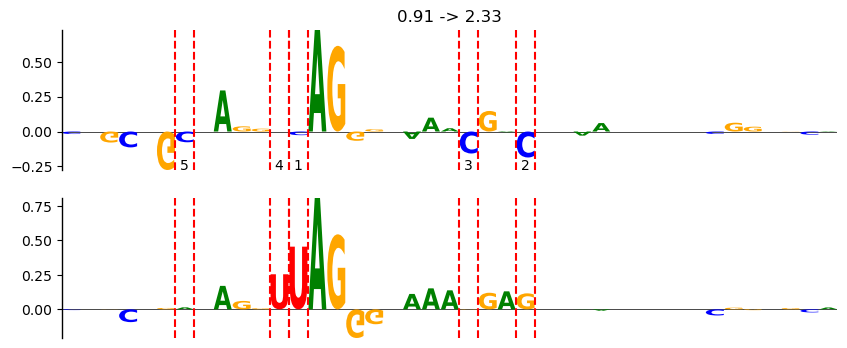

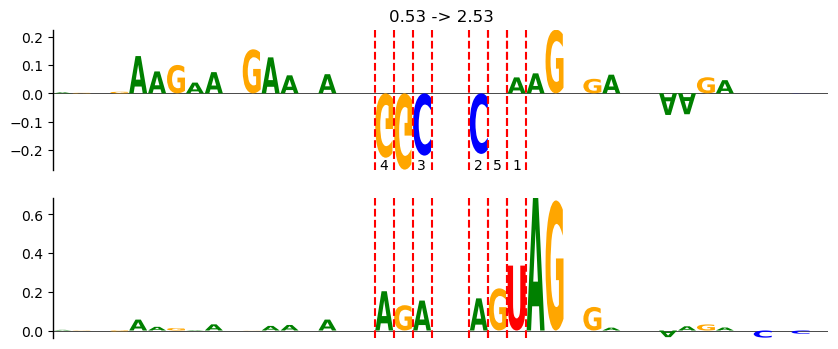

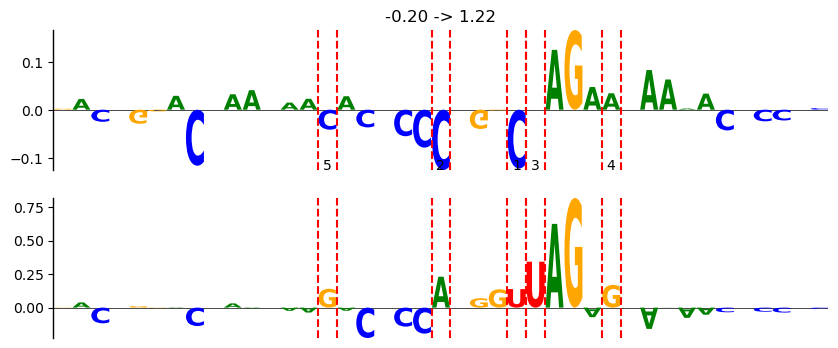

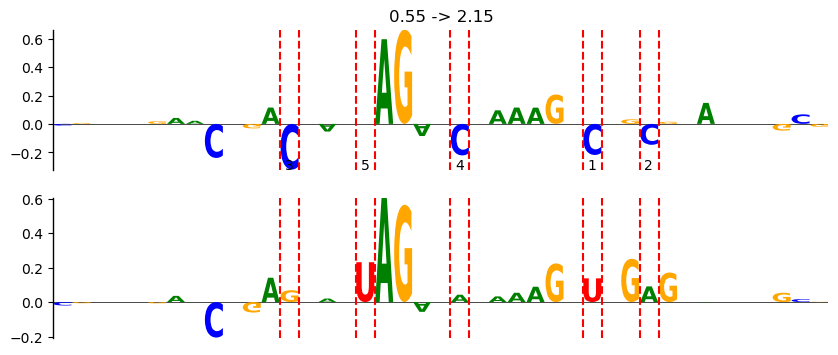

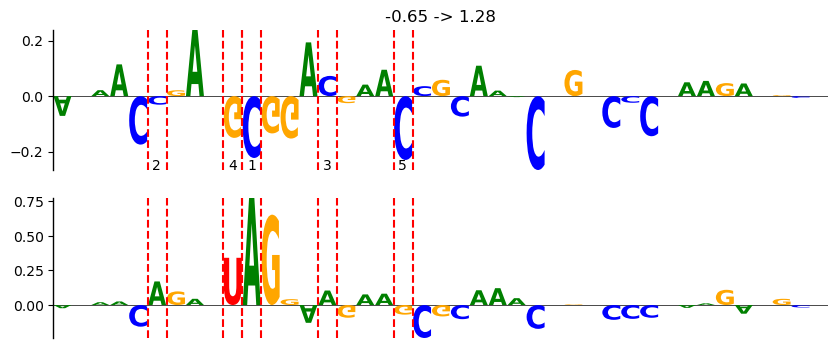

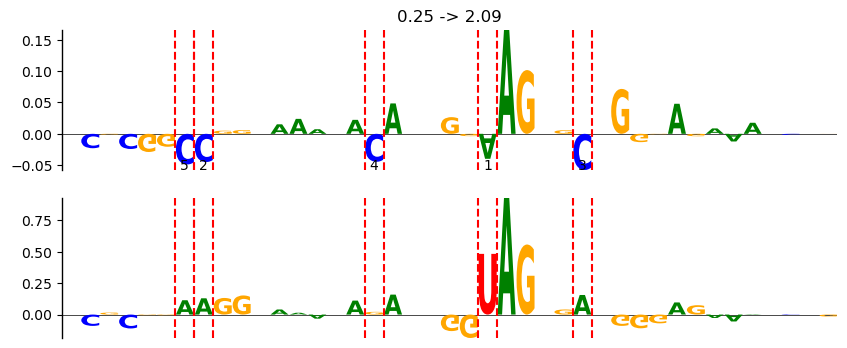

In [95]:
# Complicated plotting that we will eventually turn into a built in function
for i in range(len(random_explains)):
    fig, ax = plt.subplots(2, 1, figsize=(10, 4))
    random_viz_seq = pd.DataFrame(random_explains[i].T, columns=["A", "C", "G", "U"])
    random_viz_seq.index.name = "pos"
    random_logo = lm.Logo(random_viz_seq, color_scheme="classic", figsize=(10, 2), ax=ax[0])
    random_logo.style_spines(visible=False)
    random_logo.style_spines(spines=['left'], visible=True)
    random_logo.ax.set_xticks([])
    ax[0].vlines(mutation_pos[i]-0.5, 0, 1, transform=ax[0].get_xaxis_transform(), colors='r', linestyle='--')
    ax[0].vlines(mutation_pos[i]+0.5, 0, 1, transform=ax[0].get_xaxis_transform(), colors='r', linestyle='--')
    ax[0].set_title(f"{random_scores[i].item():.2f} -> {evolved_scores[i].item():.2f}")
    ax_bottom = ax[0].get_ylim()[0]
    for j in range(len(mutation_pos[i])):
        ax[0].annotate(f"{j+1}", xy=(mutation_pos[i][j]-0.25, ax_bottom))
    evolved_viz_seq = pd.DataFrame(evolved_explains[i].T, columns=["A", "C", "G", "U"])
    evolved_viz_seq.index.name = "pos"
    evolved_logo = lm.Logo(evolved_viz_seq, color_scheme="classic", figsize=(10, 2), ax=ax[1])
    evolved_logo.style_spines(visible=False)
    evolved_logo.style_spines(spines=['left'], visible=True)
    evolved_logo.ax.set_xticks([])
    ax[1].vlines(mutation_pos[i]-0.5, 0, 1, transform=ax[1].get_xaxis_transform(), colors='r', linestyle='--')
    ax[1].vlines(mutation_pos[i]+0.5, 0, 1, transform=ax[1].get_xaxis_transform(), colors='r', linestyle='--')
    #plt.savefig(os.path.join(#settings.figure_dir, "ise", f"randseq{i}_evolution_{rbp}.pdf"))

# Save

In [ ]:
# Save the SeqData with predictions and interpretations
sdata_test.write_h5sd(os.path.join(eu.settings.output_dir, "norm_test_predictions_and_intepretations_MTfiltersonly_0.75.h5sd"))
#sdata_test.write_h5sd(os.path.join(eu.settings.output_dir, "norm_test_predictions_and_intepretations_noMTfilters_0.75.h5sd"))

---

# Scratch